# Check GPU

In [16]:
!nvidia-smi

Sat Nov 26 06:11:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    28W /  70W |    566MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks, applications
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from imutils import paths

# Load dataset

In [18]:
CATEGORIES = ['heart', 'oblong', 'oval', 'round', 'square']
epochs=50
batch_size = 32
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)


In [19]:
trainDS = utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS331/imageDropData/train',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    color_mode='rgb',
)

testDS = utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS331/imageDropData/test',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    color_mode='rgb',
)

Found 4000 files belonging to 5 classes.
Found 1000 files belonging to 5 classes.


# Load pretrained model

In [20]:
preprocessInput = tf.keras.applications.resnet50.preprocess_input

baseModel = applications.ResNet50(input_shape=IMG_SHAPE,
              include_top=False,
              weights='imagenet')
baseModel.trainable = False

# Build model

In [21]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = preprocessInput(inputs)
x = baseModel(x, training=False)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5)(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [23]:
checkpointPath = "/content/drive/MyDrive/CS331/FaceOnly/ResNet/checkpoint/model_dropout-{epoch:02d}-{val_accuracy:.2f}.h5"

In [24]:
modelEarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    min_delta=0.025,
    verbose=1,
    mode='auto',
    restore_best_weights=False,
)

modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpointPath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose = 1,
    mode='max'
)


# Train model

In [25]:
with tf.device('/gpu:0'):
    history = model.fit(
            trainDS,
            validation_data=testDS,
            epochs=epochs,
            callbacks = [modelEarlyStopping, modelCheckpoint]
    )

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 1.8661 - accuracy: 0.4243 
Epoch 1: val_accuracy improved from -inf to 0.56900, saving model to /content/drive/MyDrive/CS331/FaceOnly/ResNet/checkpoint/model_dropout-01-0.57.h5
125/125 [==============================] - 1988s 15s/step - loss: 1.8661 - accuracy: 0.4243 - val_loss: 1.2804 - val_accuracy: 0.5690
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.7213 - accuracy: 0.7420
Epoch 2: val_accuracy improved from 0.56900 to 0.63400, saving model to /content/drive/MyDrive/CS331/FaceOnly/ResNet/checkpoint/model_dropout-02-0.63.h5
125/125 [==============================] - 20s 156ms/step - loss: 0.7213 - accuracy: 0.7420 - val_loss: 1.0933 - val_accuracy: 0.6340
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8680
Epoch 3: val_accuracy improved from 0.63400 to 0.64100, saving model to /content/drive/MyDrive/CS331/FaceOnly/ResNet/checkpoint/model_dropou

# Plot loss and accuracy

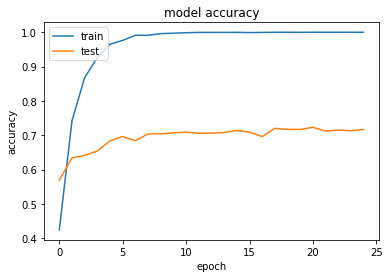

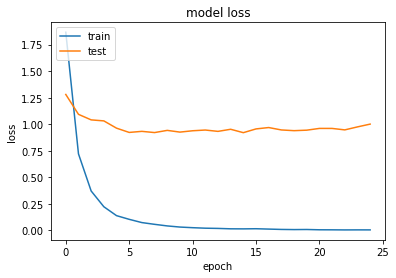

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test model

In [27]:
def loadData(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []

    for imagePath in tqdm(imagePaths):
        label = imagePath.split(os.path.sep)[-2]
        # Read image
        image = cv2.imread(imagePath)

        # Resize
        imageResize = cv2.resize(image, (224,224))


        data.append(imageResize)
        labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    lb = LabelEncoder()
    labels = lb.fit_transform(labels)
    return data, labels

In [28]:
xTest, yTest = loadData(('/content/drive/MyDrive/CS331/imageDropData/test'))

100%|██████████| 1000/1000 [00:05<00:00, 177.82it/s]


In [29]:
newModel = keras.models.load_model('/content/drive/MyDrive/CS331/FaceOnly/ResNet/checkpoint/model_dropout-21-0.72.h5')

In [30]:
zScores = newModel.predict(xTest)
yPred = np.argmax(zScores, axis=1)
corrects = (yTest == yPred).sum()
print(f'Model predict {corrects}/{len(yTest)} corrects')

32/32 [==============================] - 4s 94ms/step
Model predict 601/1000 corrects


## Confusion matrix

[]

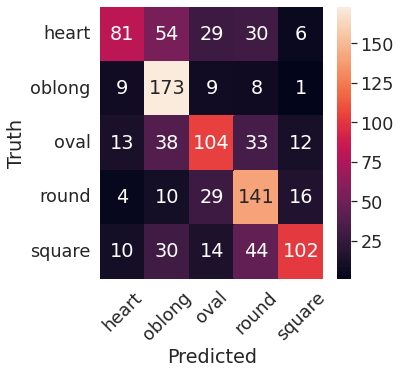

In [31]:
cm = tf.math.confusion_matrix(labels=yTest, predictions=yPred)
plt.figure(figsize=(5,5))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            yticklabels=['heart', 'oblong', 'oval', 'round', 'square'],
            )
plt.xticks(rotation=45)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.plot()


## Classification report

In [32]:
print(classification_report(yTest, yPred,target_names=['heart', 'oblong', 'oval', 'round', 'square']))

              precision    recall  f1-score   support

       heart       0.69      0.41      0.51       200
      oblong       0.57      0.86      0.69       200
        oval       0.56      0.52      0.54       200
       round       0.55      0.70      0.62       200
      square       0.74      0.51      0.61       200

    accuracy                           0.60      1000
   macro avg       0.62      0.60      0.59      1000
weighted avg       0.62      0.60      0.59      1000

